In [1]:
import os
import pylidc as pl
from pylidc.utils import consensus
from configparser import ConfigParser
import matplotlib.pyplot as plt
from statistics import median_high
import numpy as np
import pandas as pd
from pathlib import Path
import preprocessing
from tqdm import tqdm
from PIL import Image

In [2]:
DataSet_root = "./LIDC-IDRI"
Processed_data_dir = './data'
IMAGE_DIR = '/IMAGE'
MASK_DIR = '/MASK'
mask_thresh = 8

In [7]:

resize_shape = (128,128)
class prep_ds:
    DataSet_root = "./LIDC-IDRI"
    Processed_data_dir = './data'
    IMAGE_DIR = Processed_data_dir+ "/Image"
    MASK_DIR = Processed_data_dir +"/Mask"
    Clean_IMAGE_DIR =Processed_data_dir + '/CleanIMAGE'
    Clean_MASK_DIR = Processed_data_dir +'/CleanMASK'
    mask_thresh = 8

    dataFrame = pd.DataFrame(index=[],columns=['patient_id','nodule_no','slice_no','original_image','mask_image','malignancy','is_cancer','is_clean'])
    def save_dataFrame(self,meta_list):
      #saves list to csv
        tmp = pd.Series(meta_list,index=['patient_id','nodule_no','slice_no','original_image','mask_image','malignancy','is_cancer','is_clean'])
        self.dataFrame = self.dataFrame.append(tmp,ignore_index=True)
    def calc_malignancy(self,nodule):
        list_malignancy = []
        for annotation in nodule:
            list_malignancy.append(annotation.malignancy)
        malignancy = median_high(list_malignancy)
        if(malignancy>3):
            return malignancy,True
        if(malignancy<3):
            return malignancy,False
        else:
            return malignancy,"Ambiguous"

    
    def prepare_dataset(self):
            if not os.path.exists(self.IMAGE_DIR):
                os.makedirs(self.IMAGE_DIR)
            if not os.path.exists(self.MASK_DIR):
                os.makedirs(self.MASK_DIR)
            if not os.path.exists(self.Clean_IMAGE_DIR):
                os.makedirs(self.Clean_IMAGE_DIR)
            if not os.path.exists(self.Clean_MASK_DIR):
                os.makedirs(self.Clean_MASK_DIR)
            patients = os.listdir(DataSet_root)

            for patient in tqdm(patients):
                pid = patient

    
              
                scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

                nodule_annotations = scan.cluster_annotations()
                vol = scan.to_volume()
      
                patient_img_dir = Processed_data_dir + IMAGE_DIR + '/' + pid
                patient_mask_dir = Processed_data_dir + MASK_DIR + '/' + pid
                Path(patient_img_dir).mkdir(parents=True, exist_ok=True)
                Path(patient_mask_dir).mkdir(parents=True, exist_ok=True)


                if(len(nodule_annotations)>0):

                    #nodules present
                    for i,nodule in enumerate(nodule_annotations):

                        mask,cbbox,masks = pl.utils.consensus(nodule,0.5,512)
                        lung_np = vol[cbbox]
                        malignancy,cancer_label = self.calc_malignancy(nodule)
                        for mask_slice in range(mask.shape[2]):

                            if(np.sum(mask[:,:,mask_slice])<=mask_thresh):
                                continue
                            print(lung_np[:,:,mask_thresh].shape)
                            segmented_lung = preprocessing.preprocess_image(lung_np[:,:,mask_slice])
       
                            
                            nodule_name =  "Nodule"+ str(i) +"Slice" +  str(mask_slice)
                            mask_name =  "Mask"+ str(i) +"Slice" +  str(mask_slice)
                            # to save pid nodule index slice index mask name malignancy cancer label is data clean of possible cancer
                            meta_list = [pid[-4:],i,mask_slice,patient_img_dir+ '/' +nodule_name  +".png",patient_mask_dir+ '/' +mask_name+".png",malignancy,cancer_label,False]
                            self.save_dataFrame(meta_list)
                            print("Writing image to",patient_img_dir+ '/' +nodule_name)

                            image = Image.fromarray(segmented_lung*255)
                            image.save(patient_img_dir+ '/' +nodule_name+".png")                            
                            mask_img = mask[:,:,mask_slice]
                            img_mask = Image.fromarray(mask_img*255)
                            img_mask.save(patient_mask_dir+ '/' +mask_name+".png")
                            
                            #np.save(patient_img_dir+ '/' +nodule_name,segmented_lung)
                            #np.save(patient_mask_dir+ '/' +mask_name,mask_img)
                else:
                    print("no nodules",pid)
                    cleanpatient_img_dir = self.Processed_data_dir + self.Clean_IMAGE_DIR + '/' + pid
                    cleanpatient_mask_dir = self.Processed_data_dir + self.Clean_MASK_DIR + '/' + pid
                    Path(cleanpatient_img_dir).mkdir(parents=True, exist_ok=True)
                    Path(cleanpatient_mask_dir).mkdir(parents=True, exist_ok=True)
                 
                    for slice in range(vol.shape[2]):
                        if(slice>50):
                            break
                        segmented_lung = preprocessing.preprocess_image(lung_np[:,:,mask_thresh])
                        lung_mask = np.zeros_like(segmented_lung)
                        nodule_name = "Nodule"+ str(i) +"Slice" +  str(slice)
                        mask_name = "Mask"+ str(i) +"Slice" +  str(slice)
                        meta_list = [pid[-4:],i,mask_slice,cleanpatient_img_dir+ '/' +nodule_name+".png",cleanpatient_mask_dir+ '/' +mask_name+".png",0,False,True]
                        print(type(segmented_lung))
                        image = Image.fromarray(segmented_lung)
                        image.save(cleanpatient_img_dir+ '/' +nodule_name+".png")
                        img_mask = Image.fromarray(mask_img*255)
                        img_mask.save(cleanpatient_mask_dir+ '/' +mask_name+".png")
                        #np.save(cleanpatient_img_dir+ '/' +nodule_name+".npy",segmented_lung)
                        #np.save(cleanpatient_img_dir+ '/' +mask_name,mask_name)                    
                    
                    
                print("Saving CSV")
                self.dataFrame.to_csv(self.Processed_data_dir + "/dataset.csv",index = False)
                    
                    



                
               
            
            
            
            

In [8]:
ds = prep_ds()
ds.prepare_dataset()

  0%|                                                                                                                                                                                                                                                                                              | 0/70 [00:00<?, ?it/s]

Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice92
(512, 512)


  1%|███▉                                                                                                                                                                                                                                                                                  | 1/70 [00:11<12:45, 11.10s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0001/Nodule0Slice93
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice181
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice182
(512, 512)
Writin

  3%|███████▉                                                                                                                                                                                                                                                                              | 2/70 [00:37<22:28, 19.83s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0002/Nodule0Slice198
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule1Slice75
(512, 512)
Writing image to 

  4%|███████████▉                                                                                                                                                                                                                                                                          | 3/70 [01:03<25:41, 23.01s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0003/Nodule3Slice86
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0004/Nodule0Slice77


  6%|███████████████▉                                                                                                                                                                                                                                                                      | 4/70 [01:11<18:48, 17.10s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule2Slice87
(512, 512)


  7%|███████████████████▊                                                                                                                                                                                                                                                                  | 5/70 [01:21<15:47, 14.58s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0005/Nodule2Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule2Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule3Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0006/Nodule3Slice84
Saving CSV

  9%|███████████████████████▊                                                                                                                                                                                                                                                              | 6/70 [01:32<14:08, 13.26s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule1Slice118
(512, 512)
Writ

 10%|███████████████████████████▊                                                                                                                                                                                                                                                          | 7/70 [01:59<18:28, 17.59s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0007/Nodule1Slice129
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule1Slice88
(512, 512)


 11%|███████████████████████████████▊                                                                                                                                                                                                                                                      | 8/70 [02:06<14:47, 14.32s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0008/Nodule1Slice89
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice167
(512, 512)


 13%|███████████████████████████████████▋                                                                                                                                                                                                                                                  | 9/70 [02:15<12:54, 12.70s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0009/Nodule1Slice168
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule1Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice208
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice209
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice210
(512, 512)


 14%|███████████████████████████████████████▌                                                                                                                                                                                                                                             | 10/70 [02:29<13:11, 13.19s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0010/Nodule2Slice211
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice27
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice28
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice29
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule0Slice30
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule1Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule2Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule4Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule4Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule5Slice58
(512, 512)
Writing image to 

 16%|███████████████████████████████████████████▌                                                                                                                                                                                                                                         | 11/70 [02:58<17:37, 17.92s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0011/Nodule9Slice107
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice44
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule1Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule2Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule2Slice58
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule3Slice65
(512, 512)
Writing image to 

 17%|███████████████████████████████████████████████▍                                                                                                                                                                                                                                     | 12/70 [03:34<22:43, 23.50s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0012/Nodule11Slice83
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule1Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice90
(512, 512)
Writing image to 

 19%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                 | 13/70 [03:52<20:37, 21.72s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0013/Nodule2Slice94
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice75
(512, 512)


 20%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                             | 14/70 [04:00<16:18, 17.47s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0014/Nodule0Slice76
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice181
(512, 512)
Writin

 21%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                         | 15/70 [04:19<16:31, 18.02s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0015/Nodule0Slice185
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule2Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule3Slice95
(512, 512)
Writing image to 

 23%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                     | 16/70 [04:46<18:33, 20.62s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0016/Nodule5Slice131
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0017/Nodule0Slice164
Saving CSV

 24%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                 | 17/70 [04:54<14:51, 16.82s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule0Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule0Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule1Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule2Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule2Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice111
(512, 512)


 26%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                             | 18/70 [05:12<14:56, 17.23s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0018/Nodule3Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice253
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice254
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice255
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice256
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice257
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice258
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice259
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice260
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice261
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice262
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice263
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice264
(512, 512)
Writi

 27%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 19/70 [05:36<16:32, 19.46s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0019/Nodule0Slice276
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule0Slice165
(512, 512)
Writi

 29%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                     | 20/70 [05:55<16:03, 19.26s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0020/Nodule1Slice194
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice125
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice126
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice127
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice128
(512, 512)


 30%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 21/70 [06:08<14:14, 17.43s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0021/Nodule2Slice129
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice102
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice103
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice104
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice109
(512, 512)


 31%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 22/70 [06:20<12:32, 15.67s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0022/Nodule0Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice122
(512, 512)


 33%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 23/70 [06:36<12:24, 15.85s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0023/Nodule0Slice123
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule1Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule2Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule3Slice87
(512, 512)


 34%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                      | 24/70 [06:51<11:58, 15.62s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0024/Nodule3Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice223
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice224
(512, 512)


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 25/70 [06:58<09:45, 13.02s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0025/Nodule0Slice225
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0026/Nodule1Slice162


 37%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 26/70 [07:07<08:43, 11.89s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule2Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule2Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule3Slice92
(512, 512)
Writing

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 27/70 [07:32<11:12, 15.65s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0027/Nodule6Slice118
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0028
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 28/70 [08:04<14:24, 20.58s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice169
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice170
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice171
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice172
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice173
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice174
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice175
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice176
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice177
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice178
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice179
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice180
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-00

 41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 29/70 [08:22<13:28, 19.72s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0029/Nodule0Slice187
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule1Slice81
(512, 512)


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 30/70 [08:28<10:23, 15.58s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0030/Nodule1Slice82
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule3Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice112
(512, 512)
Writing imag

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 31/70 [08:47<10:53, 16.75s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0031/Nodule4Slice117
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0032
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 32/70 [09:21<13:53, 21.93s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice105
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule0Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice108
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice109
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice111
(512, 512)


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 33/70 [09:31<11:19, 18.38s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0033/Nodule1Slice112
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice97
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice98
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0034/Nodule0Slice99


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 34/70 [09:40<09:15, 15.43s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice115
(512, 512)


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 35/70 [09:44<07:06, 12.18s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0035/Nodule0Slice116
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule0Slice190
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice199
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice200
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice201
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice202
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice203
(512, 512)


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 36/70 [09:56<06:47, 11.97s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0036/Nodule1Slice204
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice106
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice107
(512, 512)


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 37/70 [10:07<06:31, 11.85s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0037/Nodule1Slice108
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0038/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0038/Nodule0Slice53


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 38/70 [10:11<04:58,  9.33s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice122
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice123
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule1Slice124
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice132
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice133
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule2Slice134
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule3Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0039/Nodule3Slice163
(512,

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 39/70 [10:38<07:38, 14.80s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule1Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule1Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule2Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule2Slice44
(512, 512)


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 40/70 [10:47<06:27, 12.90s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0040/Nodule3Slice67
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule1Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice123
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice124
(512, 512)


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 41/70 [11:00<06:20, 13.11s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0041/Nodule2Slice125
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule1Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule1Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule2Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule3Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule4Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule4Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule5Slice60
(512, 512)
Writing image to 

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 42/70 [11:22<07:16, 15.61s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0042/Nodule9Slice86
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice56
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule0Slice57
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule1Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice91
(512, 512)
Writing image to .

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 43/70 [11:40<07:18, 16.24s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0043/Nodule2Slice94
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule0Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0044/Nodule1Slice67
(512, 512)
Writing image to .

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 44/70 [12:10<08:55, 20.61s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice24
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice25
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule0Slice26
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule1Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule1Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule2Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule3Slice52
(512, 512)
Writing image to 

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 45/70 [12:57<11:52, 28.48s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0045/Nodule11Slice88
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice19
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice20
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule0Slice21
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule1Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule2Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule2Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule3Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule3Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule4Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0046/Nodule4Slice41
(512, 512)
Writing image to 

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 46/70 [13:19<10:35, 26.47s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice77
(512, 512)


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 47/70 [13:25<07:48, 20.39s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0047/Nodule0Slice78
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule0Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice164
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice165
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule1Slice166
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule2Slice187
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0048/Nodule2Slice188
(512, 512)
Writin

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 48/70 [13:44<07:15, 19.80s/it]


Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice53
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice54
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule1Slice55
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule2Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule2Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule3Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule4Slice63
(512, 512)
Writing image to 

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 49/70 [14:26<09:17, 26.56s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0049/Nodule14Slice73
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice96
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice97
(512, 512)


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 50/70 [14:39<07:27, 22.35s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0050/Nodule0Slice98
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule1Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice95
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice96
(512, 512)


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 51/70 [14:52<06:15, 19.79s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0051/Nodule2Slice97
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice221
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice222
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice223
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice224
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice225
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice226
(512, 512)
Writing imag

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 52/70 [15:19<06:33, 21.87s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice231
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice32
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice33
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice34
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice35
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice45
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice46
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice47
(512, 512)


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 53/70 [15:35<05:42, 20.13s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice48
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice84
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice85
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice87
(512, 512)


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 54/70 [15:43<04:24, 16.51s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0054/Nodule0Slice88
Saving CSV
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule0Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule1Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule2Slice94
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule3Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule3Slice101
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule4S

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 55/70 [16:04<04:28, 17.93s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0055/Nodule6Slice124
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule0Slice83
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule1Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule2Slice172
(512, 512)


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 56/70 [16:20<04:00, 17.16s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0056/Nodule2Slice173
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice153
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice154
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice155
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice156
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice157
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice158
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice159
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice160
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice161
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice162
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice163
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice164
(512, 512)
Writi

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 57/70 [16:44<04:09, 19.21s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0057/Nodule0Slice174
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice70
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice71
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule0Slice72
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice86
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice87
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule1Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule2Slice103
(512, 512)
Writing image to

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 58/70 [17:08<04:07, 20.60s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0058/Nodule2Slice110
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice99
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice100
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice101
(512, 512)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 59/70 [17:13<02:56, 16.07s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0059/Nodule0Slice102
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice61
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice62
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice63
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule1Slice64
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule2Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule2Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule3Slice83
(512, 512)
Writing image to 

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 60/70 [17:40<03:13, 19.30s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0060/Nodule5Slice99
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice47
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice48
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice49
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice50
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice51
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule1Slice52
(512, 512)
Writing image to .

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 61/70 [18:30<04:15, 28.37s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0061/Nodule5Slice99
Saving CSV
Loading dicom files ... This may take a moment.
no nodules LIDC-IDRI-0062
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.n

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 62/70 [19:01<03:53, 29.17s/it]

<class 'numpy.ndarray'>
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule0Slice59
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule0Slice60
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice65
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice66
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice67
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule1Slice68
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice88
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice90
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice91
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice92
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule2Slice93
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule3Sl

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 63/70 [19:15<02:53, 24.82s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0063/Nodule3Slice107
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice73
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice74
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice75
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice76
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice77
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice78
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice82
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice107
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice108
(512, 512)
Writing image t

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64/70 [19:38<02:25, 24.21s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0064/Nodule1Slice115
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0065/Nodule0Slice89
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0065/Nodule0Slice90


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 65/70 [19:43<01:31, 18.34s/it]

Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice443
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice444
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice445
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice446
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice447
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice448
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice449
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice450
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice451
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice452
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice453
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice454
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule0Slice455
(512,

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 66/70 [20:51<02:12, 33.21s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0066/Nodule2Slice516
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice110
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice111
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice112
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice113
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice114
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice115
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice116
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice128
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice129
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule1Slice130
(512, 512)
Writi

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 67/70 [21:15<01:31, 30.51s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0067/Nodule3Slice174
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice117
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice118
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice119
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice120
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule0Slice121
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice147
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice148
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice149
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice150
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice151
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule1Slice152
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule2Slice154
(512, 512)
Writi

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 68/70 [21:55<01:06, 33.41s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0068/Nodule5Slice218
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice36
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice37
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice38
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice39
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice40
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice41
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice42
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule0Slice43
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule1Slice52
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice81
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice82
(512, 512)
Writing image to 

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 69/70 [22:15<00:29, 29.27s/it]

Writing image to ./data/IMAGE/LIDC-IDRI-0069/Nodule2Slice86
Saving CSV
Loading dicom files ... This may take a moment.
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule0Slice69
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule1Slice79
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule1Slice80
(512, 512)
Writing image to ./data/IMAGE/LIDC-IDRI-0070/Nodule2Slice84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [22:23<00:00, 19.19s/it]

Saving CSV


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(segmented_image)

In [ ]:
segmented_image

In [18]:
img = np.load("Nodule0Slice176.npy")

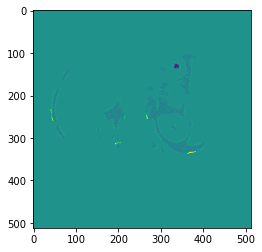

In [19]:
plt.imshow(img)

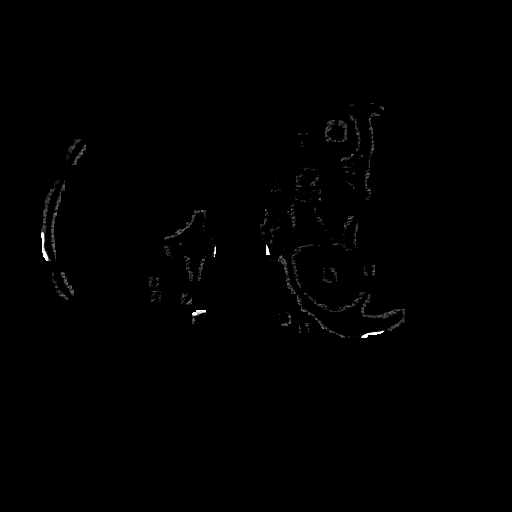

In [21]:
Image.fromarray(img*255
            )